# Analísis para Model Fitness

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. Con este analísis podremos especular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan su contrato. Para tener mayor claridad de ellos nos enfocaremos en los siguientes puntos:

- Predecir la perdida para el proximo mes de cada cliente.
- Elaboración de retrato de usarios describiendo sus características principales.
- Factores que más impactan en la perdida.
- Recomendaciones para mejorar la atención al cliente:
    - Grupos objetivo.
    - Patrones de interacción con los clientes.
    - Medidas para reducir la pérdida de clientes.

## Preparación de datos

In [1]:
# Cargar Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans


In [2]:
# Cargar datos
df = pd.read_csv('gym_churn_us.csv')

# 1. Procesamiento de datos / optimización de memoria
df.columns = df.columns.str.lower()
int_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'lifetime', 'churn']
df[int_columns] = df[int_columns].astype('int32')

float_columns = ['avg_additional_charges_total', 'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
df[float_columns] = df[float_columns].astype('float32')


## Análisis Exploratorio de datos (EDA)

- Dataset: ¿contiene alguna característica ausente? Estudia los valores promedio y la desviación estándar.
- Valores medios de las características en dos grupos: para las personas que se fueron (cancelación) y para las que se quedaron.
- Histogramas de barras y distribuciones de características para aquellas personas que se fueron (cancelación) y para las que se quedaron.
- Matriz de correlación.

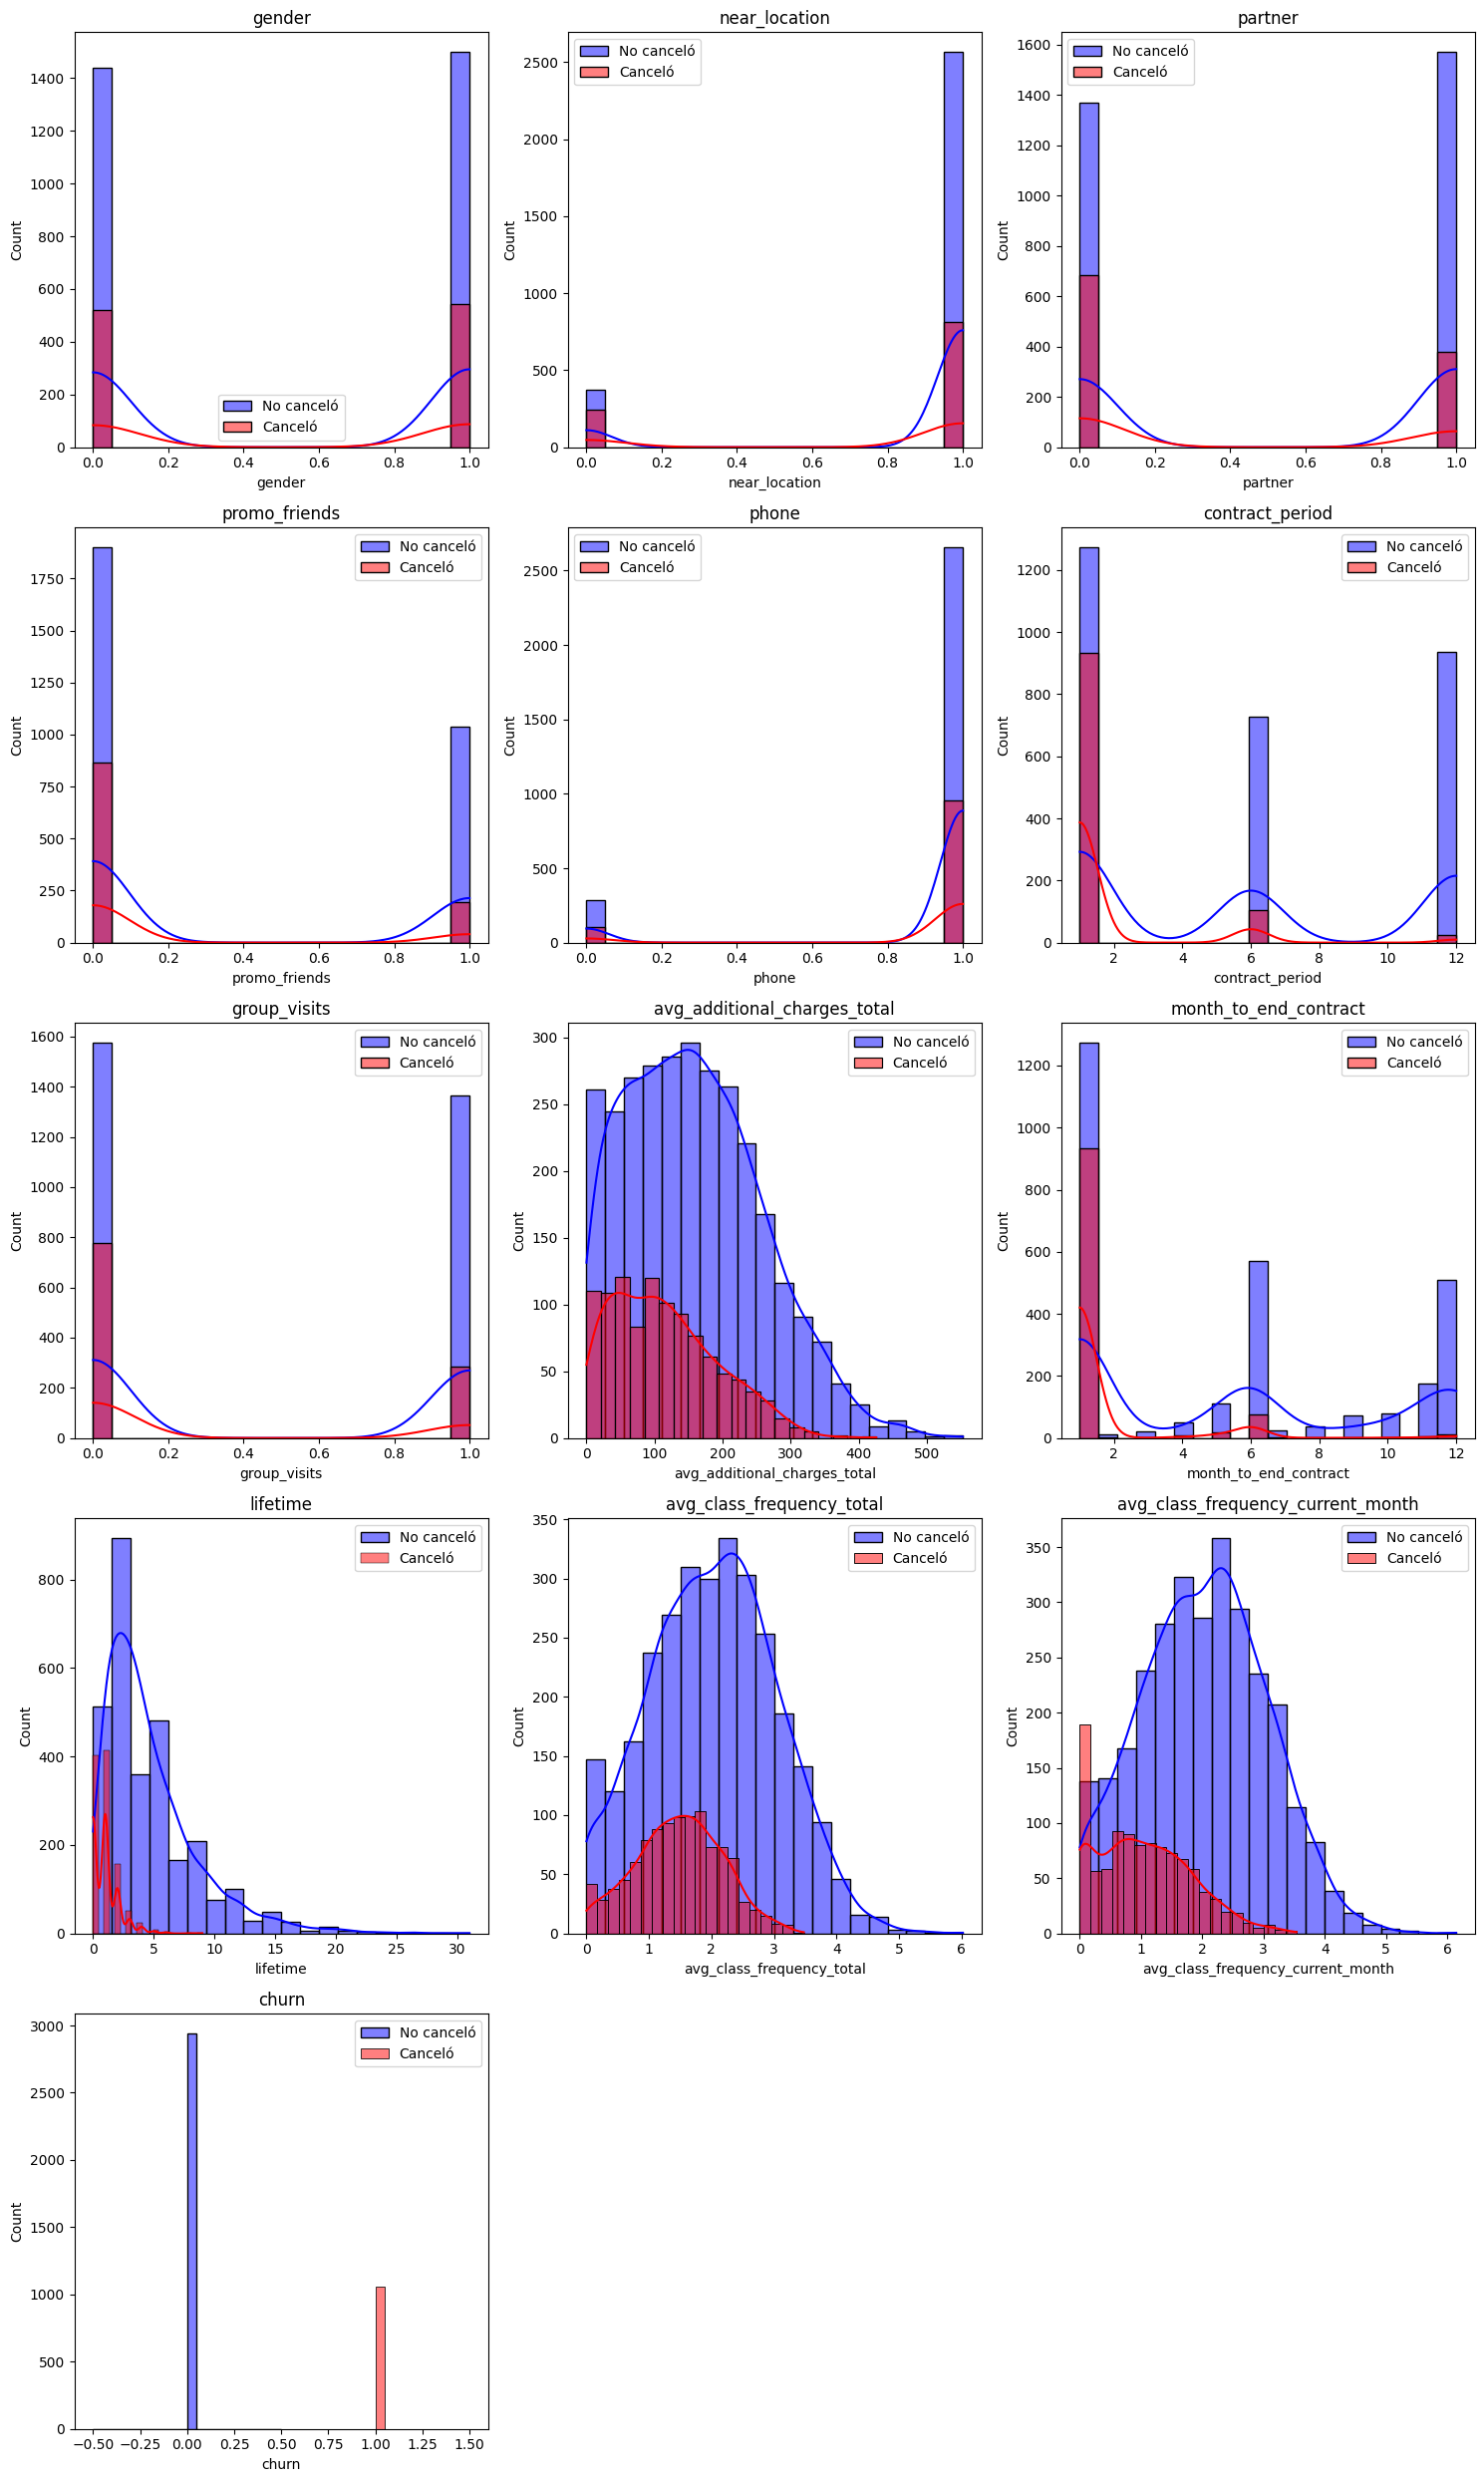

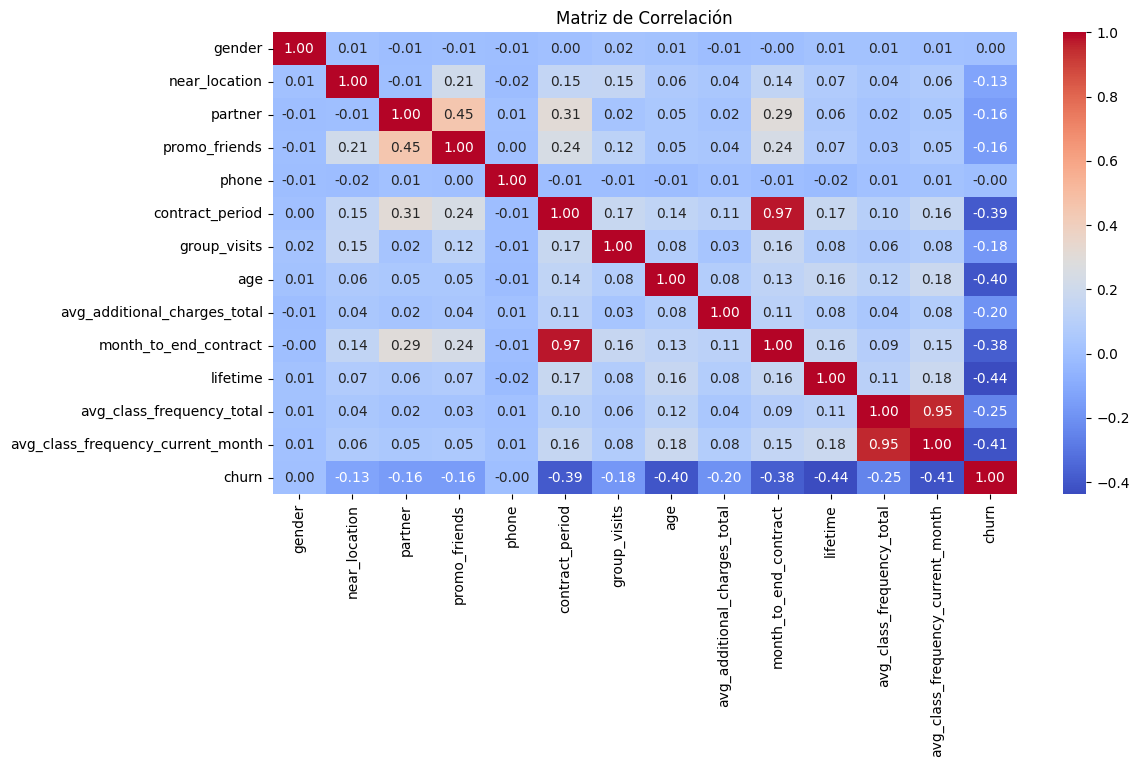

In [3]:
# Verificar datos faltantes
df_missing = df.isnull().sum()
display("Datos faltantes por columna:\n", df_missing)

# Estadísticas descriptivas
display(df.describe())

# Comparar valores medios entre personas que se quedaron y las que cancelaron
display(df.groupby('churn').mean())

# Histogramas de distribución de características
num_columns = df.select_dtypes(include=['int32', 'float32']).columns.tolist()
n_cols = 3
n_rows = int(np.ceil(len(num_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_columns):
    sns.histplot(df[df['churn'] == 0][col], ax=axes[i], color='blue', label='No canceló', kde=True, bins=20, alpha=0.5)
    sns.histplot(df[df['churn'] == 1][col], ax=axes[i], color='red', label='Canceló', kde=True, bins=20, alpha=0.5)
    axes[i].set_title(col)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación")
plt.show()

### Conclusión basada en la Matriz de Correlación e Histogramas de distribuciones
A partir de los gráficos extraídos de la data podemos inferir las siguientes conclusiones:

#### Histogramas
- Los clientes que han cancelado tienden a tener **menores tiempos de membresía**.
- Los clientes con **contratos más largos** son menos propensos a cancelar.
- Los clientes que recibieron **promociones** suelen mostrar comportamientos atípicos; para persuadirlos, se requiere de más información.
- Los clientes que **no tienen gastos adicionales** presentan una **mayor tasa de cancelación**. Esto sugiere que podrían no estar al tanto de las amenidades extra que podrían disfrutar.

#### Correlación
- **Mayor tiempo en el gimnasio** → menor probabilidad de cancelación (*lifetime*).
- **Mayor frecuencia de asistencia** → menor tendencia a cancelar.
- **Contratos más largos** → menor tendencia de cancelación.
- **Asistencia en grupo** → menor tasa de cancelación.

### Factores clave en la cancelación
Los principales factores que impactan la retención de clientes son:  
✔ **Contratos largos**  
✔ **Mayor tiempo de membresía**  
✔ **Mayor frecuencia de asistencia**  

Esto indica que **la tasa de retención mejora cuando el cliente este comprometido con el gimnasio**.

### Recomendaciones para reducir cancelaciones
 **Fomentar la asistencia**: Ofrecer recompensas a clientes con asistencia frecuente.  
 **Incentivar contratos más largos**: Ofrecer descuentos o beneficios extra a quienes renueven por períodos prolongados.  
 **Promover visitas grupales**: Organizar actividades o brindar descuentos a grupos.  
 **Aumentar ingresos adicionales (promover amenidades)**: Diseñar estrategias para que los clientes gasten más en servicios adicionales, como descuentos especiales o promociones en amenidades.

## Modelo de predición

Los modelos expuestos en el análisis nos ayudaran a tomar una decisión sobre cual usaremos.

In [4]:
# Construcción del modelo de predicción
X = df.drop(columns=['churn'])
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Regresión Logística
log_model = LogisticRegression(random_state=0, max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Bosque Aleatorio
rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluación de Modelos
def evaluar_modelo(y_true, y_pred, modelo):
    print(f"Evaluación del modelo: {modelo}")
    print("Exactitud:", accuracy_score(y_true, y_pred))
    print("Precisión:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("-")

evaluar_modelo(y_test, y_pred_log, "Regresión Logística")
evaluar_modelo(y_test, y_pred_rf, "Bosque Aleatorio")

### Conclusión sobre los Modelos de Predicción

Se evaluaron dos modelos de clasificación para predecir la variable objetivo: **Regresión Logística** y **Bosque Aleatorio**. 

**Hallazgos clave:**

1. **Regresión Logística**
   - **Exactitud**: 92.38%
   - **Precisión**: 85.86%
   - **Recall**: 82.83%
   - Presenta una **mayor exactitud y precisión** en comparación con el Bosque Aleatorio. Esto indica que clasifica correctamente la mayoría de los casos y tiene una menor tasa de falsos positivos.
   - Su **recall también es más alto**, lo que significa que es capaz de identificar más casos positivos correctamente.

2. **Bosque Aleatorio**
   - **Exactitud**: 91.63%
   - **Precisión**: 83.94%
   - **Recall**: 81.82%
   - Aunque es un modelo robusto, su **exactitud y precisión son ligeramente menores** en comparación con la Regresión Logística.
   - Su recall también es un poco más bajo, lo que indica que podría estar clasificando incorrectamente algunos casos positivos.

### Conclusión Final
- **La Regresión Logística supera al Bosque Aleatorio en métricas**, por lo que parece ser la mejor opción para este problema.
- Sin embargo, la diferencia entre ambos modelos es relativamente pequeña. La **Regresión Logística** nos ayudara a maximizar la interpretabilidad y la eficiencia computacional, pero el modelo **Bosque Aleatorio** nos ayudara con el manejo de relaciones no lineales, tendrá mejor manejo en la estimación de importancia de variables, y tendra mejor capacidad para manejar el volumen de datos.

Por lo que nos quedaremos con **Bosque Aleatorio** dado al tipo de modelo que requerimos y la diferencia es relativamente pequeña.

## Creación de clústeres de suarios/as

Estandarizaremos los datos para crear una matriz de distancia basada en caracteristicas estanzarizada y trazar un dendograma que nos dara visibilidad sobre la retención de los clientes.

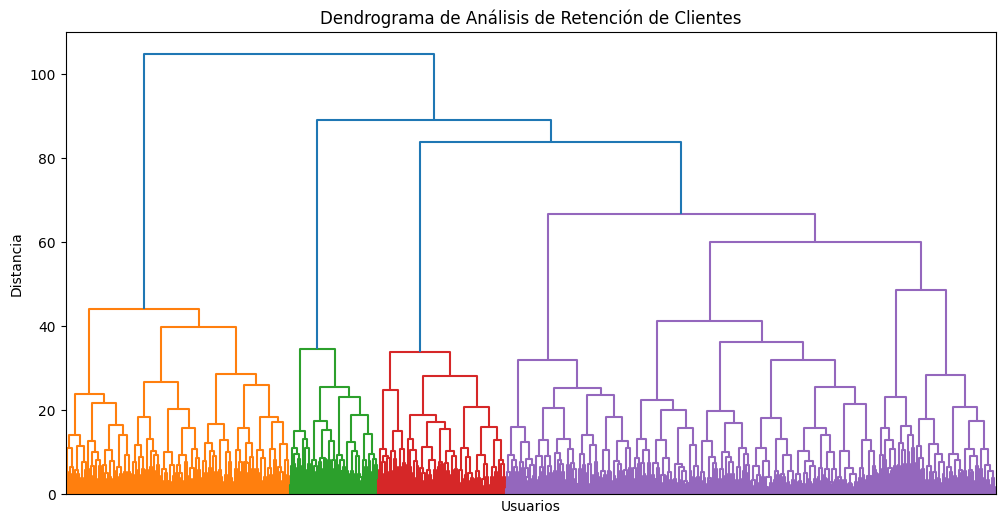

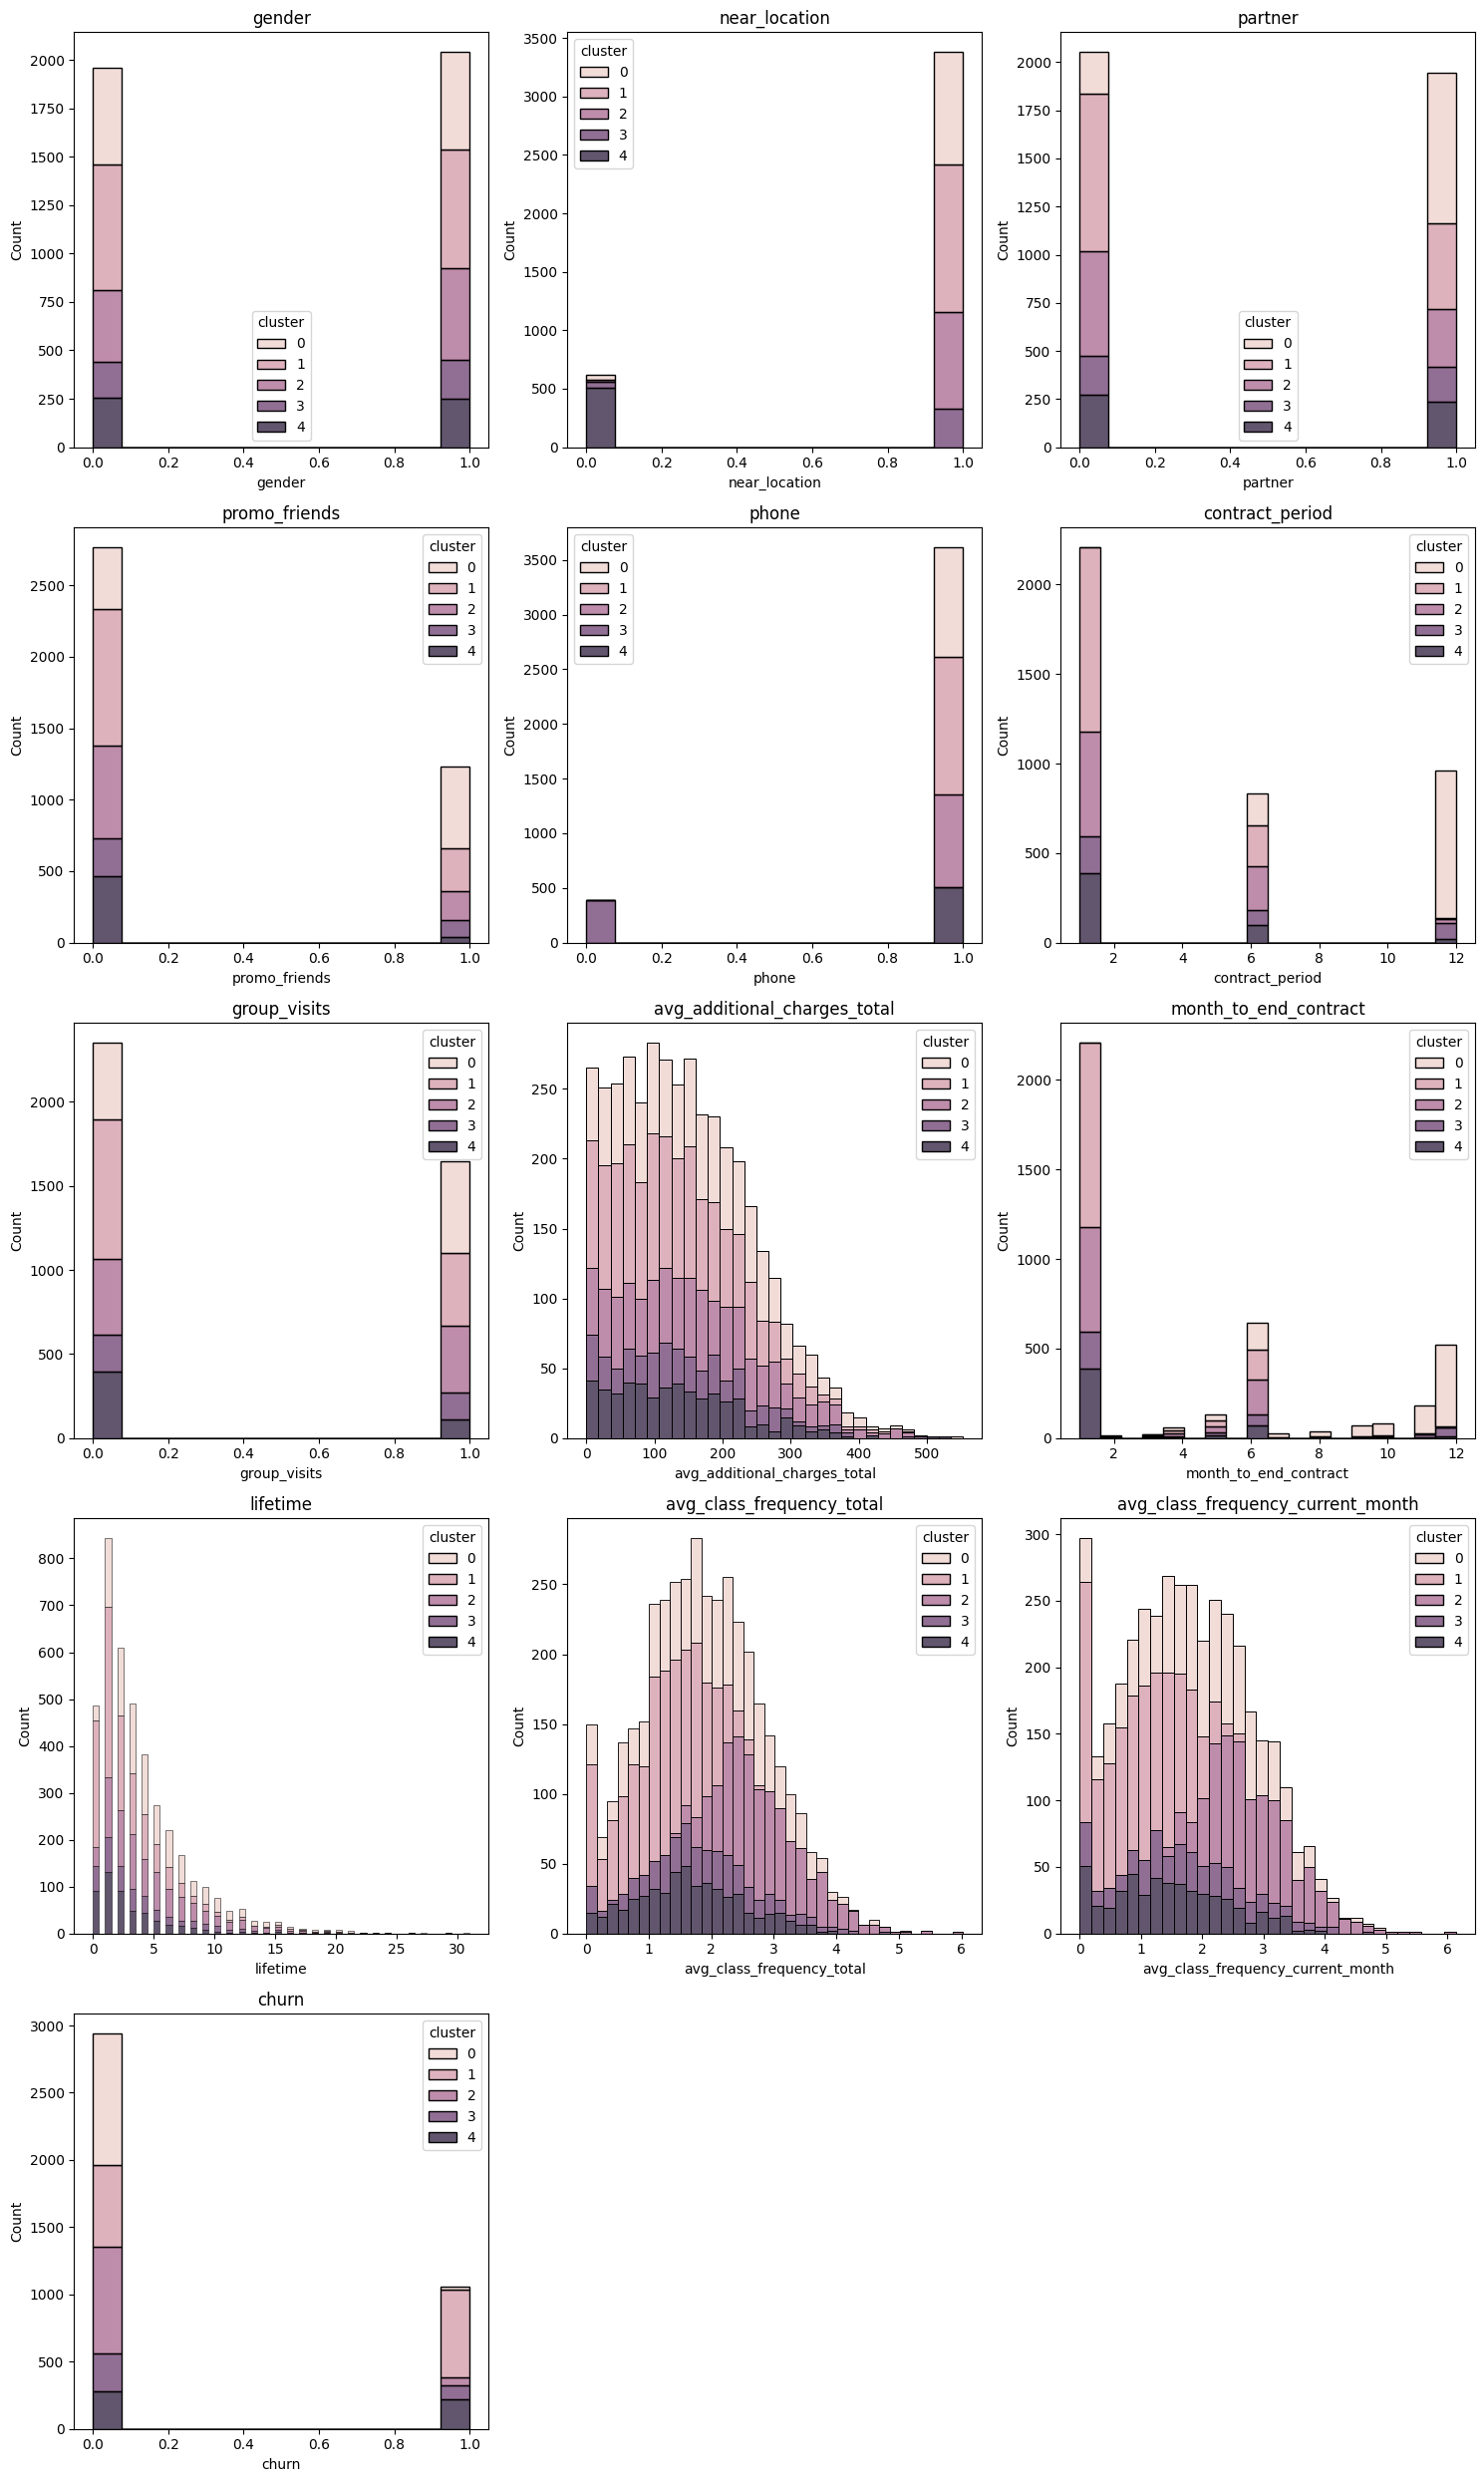

In [5]:
# Clustering
X_cluster = df.drop(columns=['churn'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Dendrograma
plt.figure(figsize=(12, 6))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrograma de Análisis de Retención de Clientes")
plt.xlabel("Usuarios")
plt.ylabel("Distancia")
plt.xticks([])
plt.show()

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=20, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Comparación de valores medios por clúster
display(df.groupby('cluster').mean())

# Distribuciones de características por clúster
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_columns):
    sns.histplot(df, x=col, hue='cluster', multiple='stack', ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Tasa de cancelación por clúster
display(df.groupby('cluster')['churn'].mean())


### Conclusión clústeres de suarios/as y Dendograma

#### Clústeres de Clientes

En el dendrograma, los "clústeres 1, 2, 3 y 4" representan grupos de clientes que han sido agrupados en función de ciertas características y patrones similares. Los algoritmos de clustering se utilizan para identificar estos patrones y segmentar los datos en grupos o clústeres.

1. **Clúster 0**: Este grupo de clientes comparte características específicas, como una alta frecuencia de asistencia y contratos largos. Podrían ser clientes muy comprometidos con el gimnasio.
2. **Clúster 1**: Este grupo podría tener clientes que tienden a cancelar más frecuentemente y tienen menores tiempos de membresía. Podrían necesitar incentivos para aumentar su retención.
3. **Clúster 2**: Este clúster podría incluir clientes que aprovechan las promociones y tienen comportamientos atípicos. Podrían necesitar estrategias personalizadas para mantenerlos interesados.
4. **Clúster 3**: Este grupo podría representar clientes con gastos adicionales promedio elevados y menor tasa de cancelación, lo que indica que están utilizando más amenidades.
5. **Clúster 4**: Podría incluir clientes que asisten en grupo y tienen una menor tasa de cancelación. Los programas de visitas grupales y eventos podrían ser efectivos para ellos.

#### Conclusión del Dendrograma

El dendrograma revela que los usuarios pueden ser agrupados en varios clústeres distintos basados en sus patrones de retención. Los grupos más grandes se encuentran en niveles más altos del dendrograma, mientras que los subgrupos más específicos se encuentran en niveles más bajos. Este tipo de análisis es útil para identificar segmentos de clientes con comportamientos similares, lo que puede ayudar a las empresas a desarrollar estrategias de retención más efectivas y personalizadas para cada grupo.


# Conclusión y recomendaciones sobre el manejo de clientes

Se identificaron factores clave que influyen en la retención de clientes, como los contratos largos, el tiempo de membresía y la frecuencia de asistencia. El análisis de los histogramas y la matriz de correlación mostró que los clientes con contratos más largos, los que disfrutan las amenidades, tienen mas frecuencia de asistencia, y los que asisten en grupo tienen menores tasas de cancelación; aquellos que aprovechan las promociones tienen comportamientos irregulares. Estos insights permiten formular estrategias efectivas para la interacción y retención de clientes.

### Recomendaciones

1. **Fomentar la asistencia frecuente**
   - **Implementación**: Crear un programa de recompensas para clientes que asistan frecuentemente al gimnasio.
   - **Ejemplo**: Ofrecer descuentos en productos o servicios adicionales después de un cierto número de visitas. Por ejemplo, un cliente podría recibir un 10% de descuento en una clase especial después de completar 10 visitas en un mes.

2. **Incentivar la firma de contratos largos**
   - **Implementación**: Ofrecer beneficios extra o descuentos a aquellos clientes que firmen contratos a largo plazo.
   - **Ejemplo**: Brindar un mes gratuito por cada año de contrato firmado. Por ejemplo, un cliente que firme un contrato de 2 años podría recibir 2 meses adicionales gratuitos.

3. **Promover visitas grupales**
   - **Implementación**: Organizar actividades especiales o brindar descuentos a grupos que visiten el gimnasio juntos.
   - **Ejemplo**: Crear eventos de entrenamiento en grupo con tarifas reducidas. Por ejemplo, un grupo de 5 personas podría recibir un 20% de descuento en una sesión de entrenamiento grupal.

4. **Aumentar ingresos adicionales mediante la promoción de amenidades**
   - **Implementación**: Diseñar estrategias para que los clientes gasten más en servicios adicionales.
   - **Ejemplo**: Ofrecer promociones en servicios de spa, clases especiales o productos de la tienda del gimnasio. Por ejemplo, un cliente podría recibir un 15% de descuento en un paquete de spa al adquirir una membresía anual.